In [8]:
import numpy as np
import random
from shapely.geometry import Point, MultiPoint
from scipy.optimize import differential_evolution as scipy_de
from shapely.ops import nearest_points

import voronoi_utils as vu
import solvers

def is_feasible(n, fixed, polygon, A_min, params, solver="custom"):
    if n == 0:
        _, areas = vu.get_voronoi_cells_and_areas(fixed, polygon)
        ok = min(areas) >= A_min
        print(f"[n=0] {'feasible' if ok else 'not feasible'}")
        if ok:
            vu.plot_voronoi(fixed, [], polygon)
        return ok, []

    # DE/GA bounds
    minx, miny, maxx, maxy = polygon.bounds
    bounds = [(minx, maxx), (miny, maxy)] * n

    def loss(x):
        pts = [(x[i], x[i+1]) for i in range(0, len(x), 2)]
        for xi, yi in pts:
            if not polygon.contains(Point(xi, yi)):
                return 1e6
        _, areas = vu.get_voronoi_cells_and_areas(fixed + pts, polygon)
        return -min(areas)

    if solver == "custom":
        bx, bf = solvers.differential_evolution_custom(loss, bounds, polygon, A_min, params)
    elif solver == "scipy":
        res = scipy_de(loss, bounds,
                       maxiter=params["maxiter"],
                       popsize=params["popsize"],
                       seed=params.get("seed", None),
                       updating="deferred")
        bx, bf = res.x, res.fun
    elif solver == "qpso":
        bx, bf = solvers.qpso_solver(loss, bounds, polygon, A_min, params)
    elif solver == "qpso2":
        bx, bf = solvers.qpso_pairwise_solver(loss, bounds, polygon, A_min, params)
    elif solver == "ga":
        bx, bf = solvers.ga_solver(loss, bounds, polygon, A_min, params)
    else:
        raise ValueError("Unknown solver")

    best_min = -bf
    ok = best_min >= A_min
    print(f"[n={n}] {'feasible' if ok else 'not feasible'} with min_cell_area = {best_min:.4f}")
    if ok:
        added = [(bx[i], bx[i+1]) for i in range(0, len(bx), 2)]
        vu.plot_voronoi(fixed, added, polygon)
        return True, added
    return False, []

def find_max_additional(fixed, polygon, A_min, params, solver="custom"):
    print(f"Minimum area threshold (A_min): {A_min:.4f}")
    ok, _ = is_feasible(0, fixed, polygon, A_min, params, solver)
    if not ok:
        return 0, []

    low, n = 0, 1
    best_added = []
    while True:
        ok, added = is_feasible(n, fixed, polygon, A_min, params, solver)
        if not ok:
            break
        low, best_added = n, added
        n *= 2

    print(f"Starting binary search between n={low} (feasible) and n={n} (infeasible)")
    lo, hi = low, n
    while lo < hi - 1:
        mid = (lo + hi) // 2
        ok, added = is_feasible(mid, fixed, polygon, A_min, params, solver)
        if ok:
            lo, best_added = mid, added
        else:
            hi = mid

    print(f"Result → Max extra points: {lo}")
    return lo, best_added



=== Custom DE ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


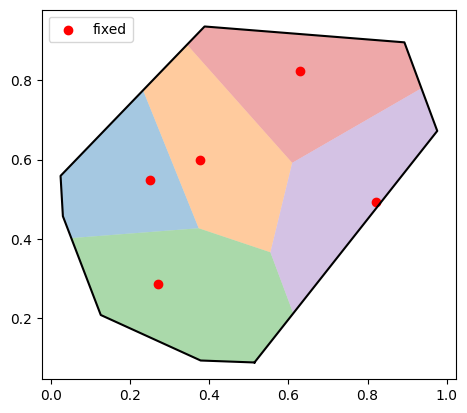

[n=1] feasible with min_cell_area = 0.0745
Voronoi cell areas: ['0.0745', '0.0906', '0.0889', '0.118', '0.0804', '0.087']


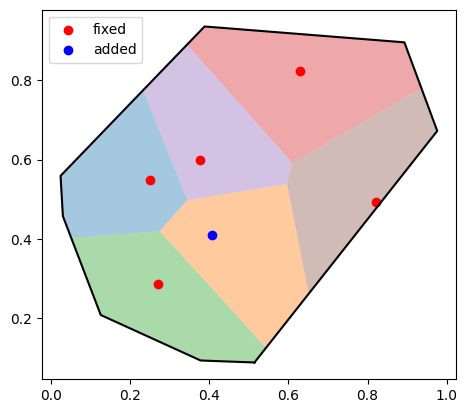

[n=2] feasible with min_cell_area = 0.0594
Voronoi cell areas: ['0.0781', '0.103', '0.0713', '0.0778', '0.0594', '0.0722', '0.0779']


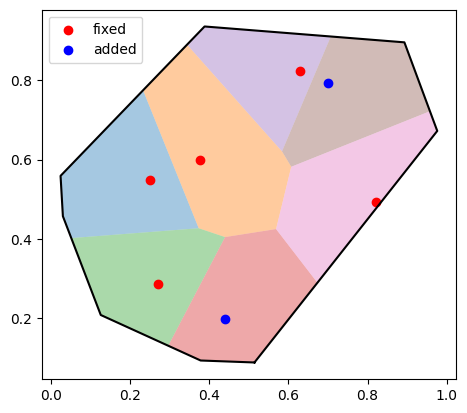

[n=4] feasible with min_cell_area = 0.0424
Voronoi cell areas: ['0.0485', '0.0462', '0.0473', '0.11', '0.0459', '0.0424', '0.0781', '0.0685', '0.0529']


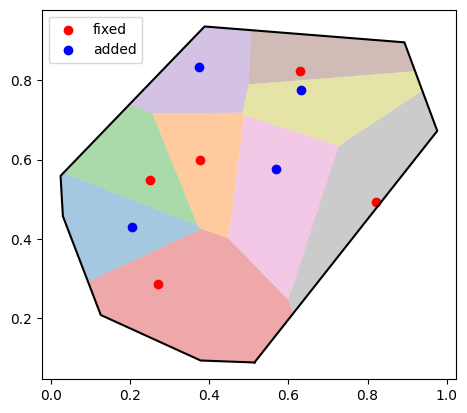

[n=8] not feasible with min_cell_area = 0.0268
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0383
Voronoi cell areas: ['0.0399', '0.0435', '0.0431', '0.0583', '0.0407', '0.0565', '0.0669', '0.0475', '0.0644', '0.0408', '0.0383']


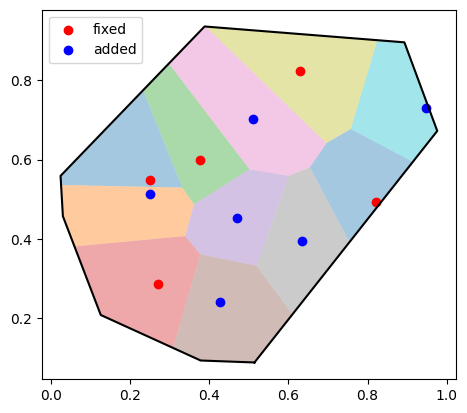

[n=7] not feasible with min_cell_area = 0.0308
Result → Max extra points: 6

=== SciPy DE ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


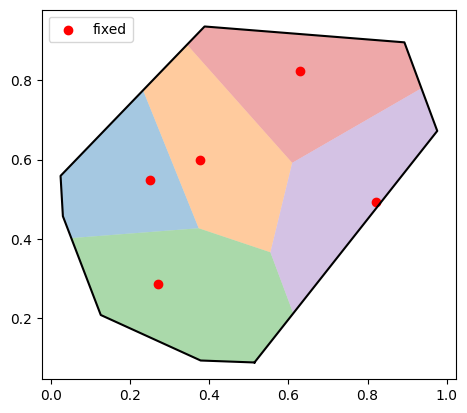

[n=1] feasible with min_cell_area = 0.0781
Voronoi cell areas: ['0.0781', '0.0976', '0.079', '0.0844', '0.118', '0.0822']


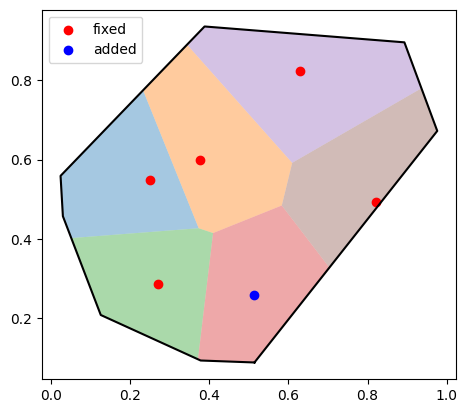

[n=2] feasible with min_cell_area = 0.0730
Voronoi cell areas: ['0.0781', '0.073', '0.0768', '0.0733', '0.073', '0.0859', '0.0796']


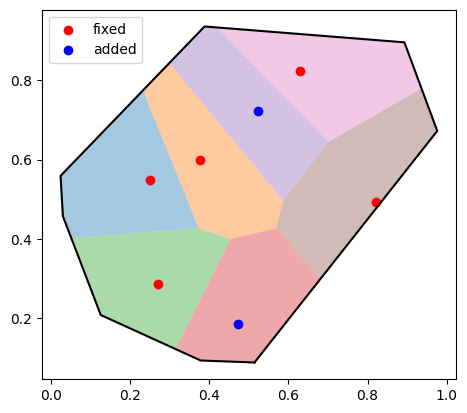

[n=4] feasible with min_cell_area = 0.0573
Voronoi cell areas: ['0.0725', '0.0574', '0.0573', '0.0587', '0.0574', '0.0642', '0.0576', '0.0574', '0.0573']


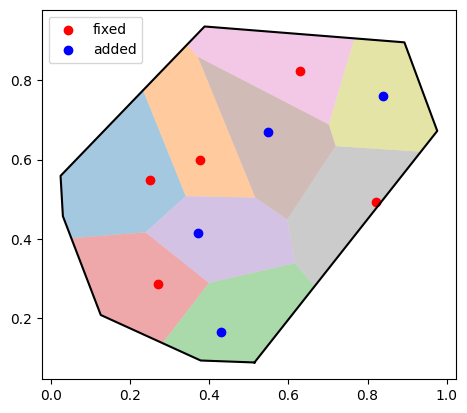

[n=8] not feasible with min_cell_area = 0.0354
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0473
Voronoi cell areas: ['0.0473', '0.0473', '0.0475', '0.0476', '0.0529', '0.0536', '0.0474', '0.0473', '0.0513', '0.0489', '0.0485']


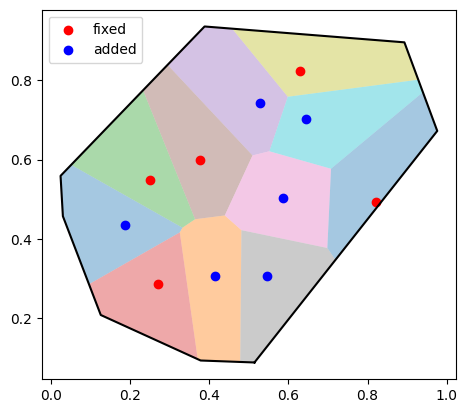

[n=7] feasible with min_cell_area = 0.0382
Voronoi cell areas: ['0.0382', '0.0383', '0.0387', '0.0393', '0.0382', '0.0747', '0.0382', '0.0551', '0.039', '0.0382', '0.041', '0.061']


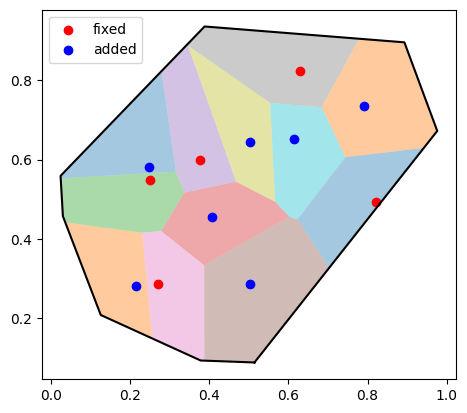

Result → Max extra points: 7

=== QPSO (original) ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


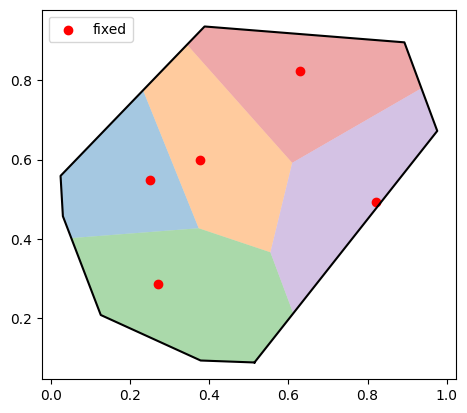

[n=1] feasible with min_cell_area = 0.0712
Voronoi cell areas: ['0.0781', '0.0716', '0.134', '0.0914', '0.0929', '0.0712']


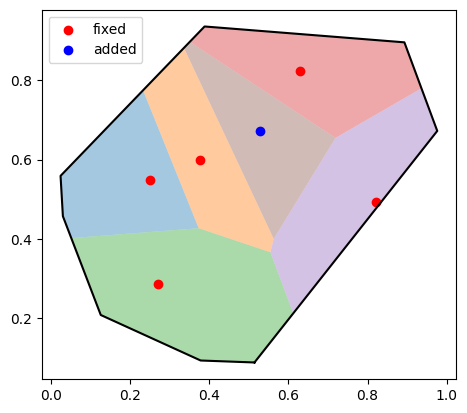

[n=2] feasible with min_cell_area = 0.0609
Voronoi cell areas: ['0.0777', '0.0708', '0.134', '0.0629', '0.0632', '0.0697', '0.0609']


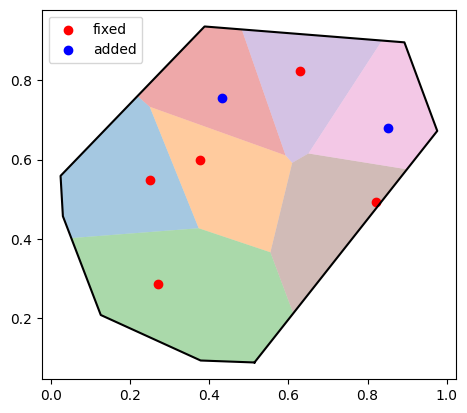

[n=4] feasible with min_cell_area = 0.0458
Voronoi cell areas: ['0.0498', '0.0564', '0.0458', '0.0476', '0.0694', '0.0887', '0.076', '0.0575', '0.0486']


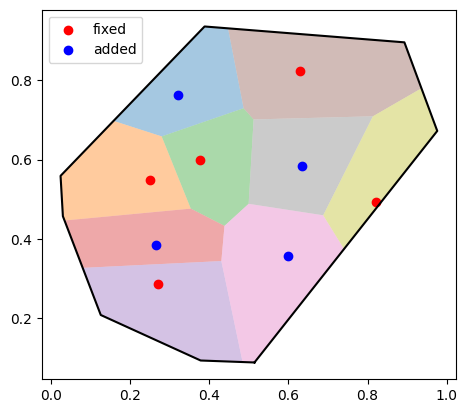

[n=8] feasible with min_cell_area = 0.0366
Voronoi cell areas: ['0.0471', '0.0432', '0.0385', '0.0368', '0.0375', '0.0457', '0.039', '0.0431', '0.039', '0.0366', '0.0443', '0.051', '0.0381']


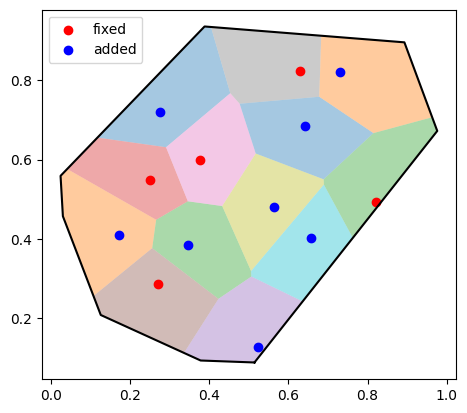

[n=16] not feasible with min_cell_area = 0.0127
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0203
[n=10] not feasible with min_cell_area = 0.0265
[n=9] not feasible with min_cell_area = 0.0283
Result → Max extra points: 8

=== QPSO (pairwise) ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


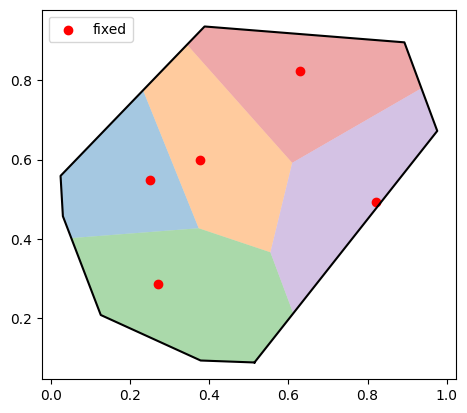

[n=1] feasible with min_cell_area = 0.0744
Voronoi cell areas: ['0.0744', '0.0904', '0.0865', '0.118', '0.0822', '0.088']


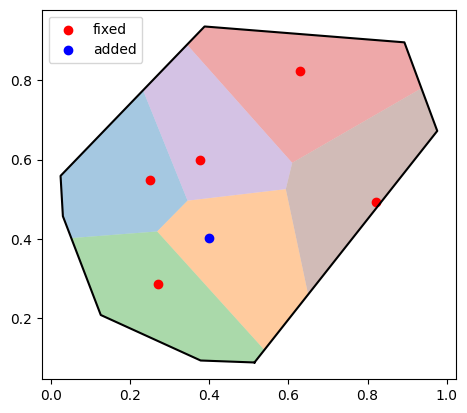

[n=2] feasible with min_cell_area = 0.0569
Voronoi cell areas: ['0.0781', '0.0641', '0.129', '0.069', '0.0722', '0.0709', '0.0569']


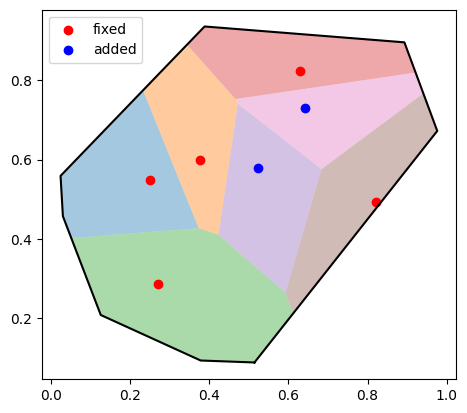

[n=4] feasible with min_cell_area = 0.0369
Voronoi cell areas: ['0.0369', '0.0513', '0.0448', '0.0389', '0.0911', '0.0748', '0.0738', '0.0876', '0.0408']


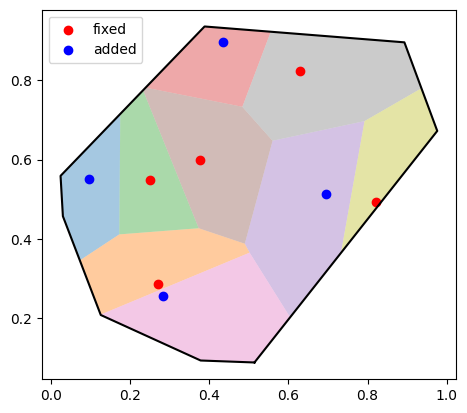

[n=8] not feasible with min_cell_area = 0.0318
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0382
Voronoi cell areas: ['0.0752', '0.0412', '0.0415', '0.0624', '0.0382', '0.047', '0.0529', '0.0411', '0.0419', '0.0592', '0.0392']


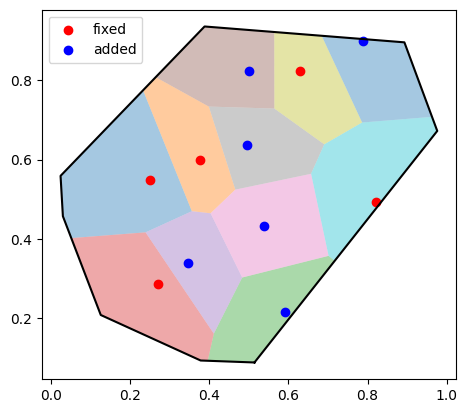

[n=7] feasible with min_cell_area = 0.0364
Voronoi cell areas: ['0.0369', '0.0473', '0.0397', '0.0509', '0.0389', '0.0364', '0.0611', '0.0563', '0.0384', '0.0402', '0.0411', '0.0525']


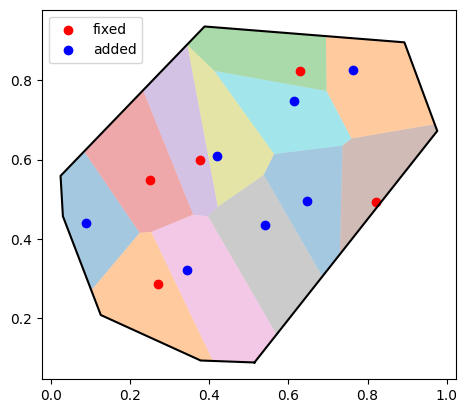

Result → Max extra points: 7

=== GA Solver ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


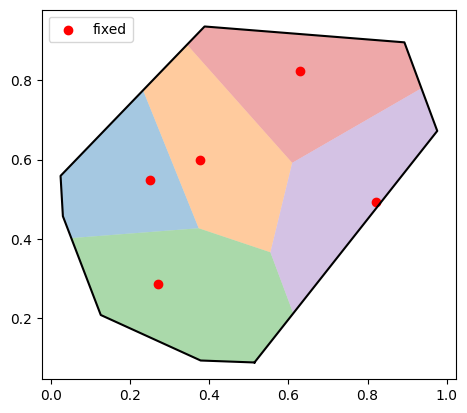

[n=1] feasible with min_cell_area = 0.0767
Voronoi cell areas: ['0.0781', '0.0933', '0.0847', '0.118', '0.0886', '0.0767']


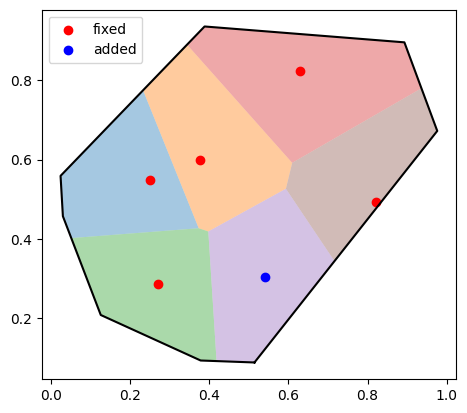

[n=2] feasible with min_cell_area = 0.0647
Voronoi cell areas: ['0.0781', '0.104', '0.0868', '0.0647', '0.0701', '0.0711', '0.0647']


/home/kamiar/chevron/Voronoi-for-oil/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/kamiar/chevron/Voronoi-for-oil/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


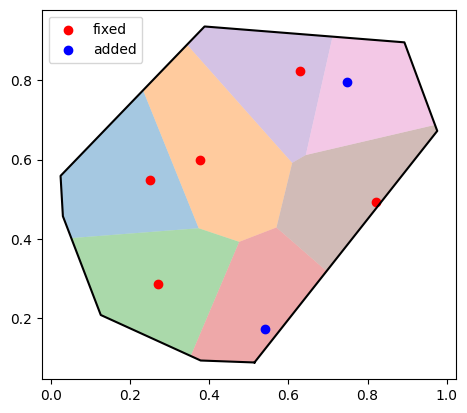

[n=4] feasible with min_cell_area = 0.0489
Voronoi cell areas: ['0.0781', '0.0676', '0.0493', '0.0776', '0.0489', '0.0642', '0.0522', '0.0523', '0.0495']


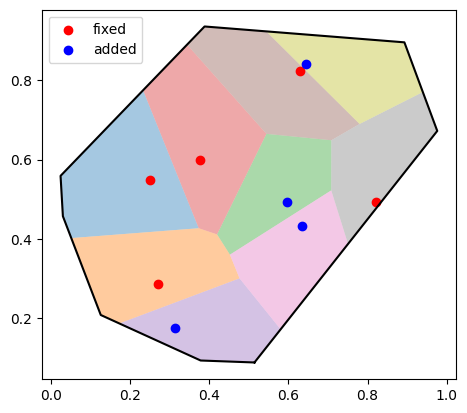

[n=8] feasible with min_cell_area = 0.0361
Voronoi cell areas: ['0.045', '0.0361', '0.0461', '0.0445', '0.0449', '0.0478', '0.0377', '0.0477', '0.0377', '0.0384', '0.0377', '0.0379', '0.0382']


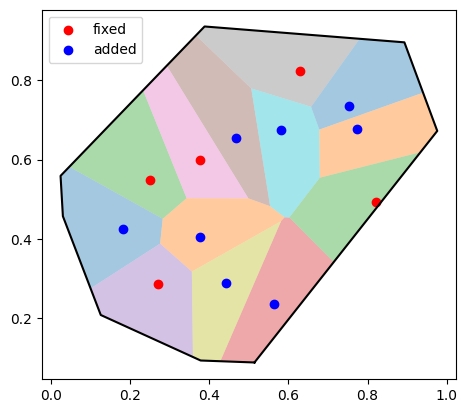

[n=16] not feasible with min_cell_area = 0.0170
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0240
[n=10] not feasible with min_cell_area = 0.0277
[n=9] not feasible with min_cell_area = 0.0337
Result → Max extra points: 8


In [9]:
# --------------------------
# Example usage
# --------------------------
if __name__ == "__main__":
    random.seed(3)
    np.random.seed(3)

    pts = np.random.rand(30, 2)
    polygon = MultiPoint([tuple(p) for p in pts]).convex_hull

    fixed = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(fixed) < 5:
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        if polygon.contains(Point(x, y)):
            fixed.append((x, y))

    A_min = polygon.area / 15

    custom_params = {"maxiter": 100, "popsize": 15, "F": 0.8, "CR": 0.7, "seed": None}
    scipy_params  = {"maxiter": 100, "popsize": 15, "seed": None}
    qpso_params   = {"maxiter": 100, "popsize": 15, "alpha": 0.75, "seed": None}
    ga_params     = {
        "popsize": 50,
        "ngen": 40,
        "cxpb": 0.6,
        "mutpb": 0.3,
        "sigma": 0.1,
        "indpb": 0.1,
        "seed": None
    }

    print("=== Custom DE ===")
    find_max_additional(fixed, polygon, A_min, custom_params, solver="custom")

    print("\n=== SciPy DE ===")
    find_max_additional(fixed, polygon, A_min, scipy_params, solver="scipy")

    print("\n=== QPSO (original) ===")
    find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso")

    print("\n=== QPSO (pairwise) ===")
    find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso2")

    print("\n=== GA Solver ===")
    find_max_additional(fixed, polygon, A_min, ga_params, solver="ga")


=== Custom DE ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


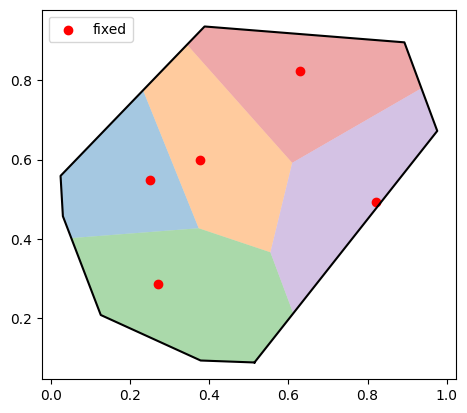

[n=1] feasible with min_cell_area = 0.0753
Voronoi cell areas: ['0.0781', '0.0978', '0.134', '0.0762', '0.0778', '0.0753']


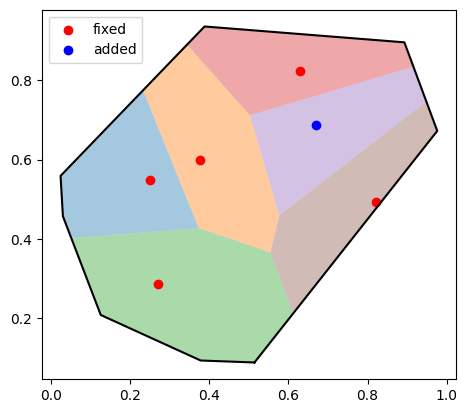

[n=2] feasible with min_cell_area = 0.0647
Voronoi cell areas: ['0.0694', '0.0684', '0.0647', '0.0864', '0.0691', '0.0946', '0.0872']


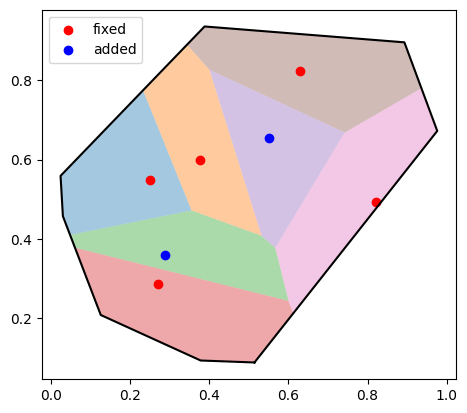

[n=4] feasible with min_cell_area = 0.0389
Voronoi cell areas: ['0.0768', '0.0389', '0.0741', '0.0818', '0.0591', '0.0607', '0.0415', '0.0491', '0.0577']


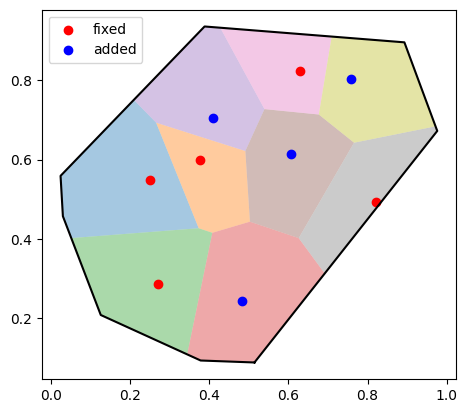

[n=8] not feasible with min_cell_area = 0.0285
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0373
Voronoi cell areas: ['0.0373', '0.0508', '0.0671', '0.0598', '0.0442', '0.0615', '0.0411', '0.0566', '0.0385', '0.045', '0.0378']


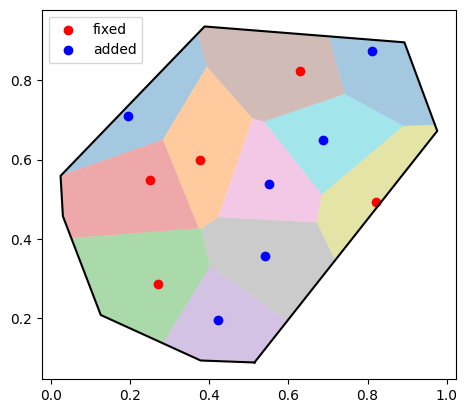

[n=7] not feasible with min_cell_area = 0.0334
Result → Max extra points: 6

=== SciPy DE ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


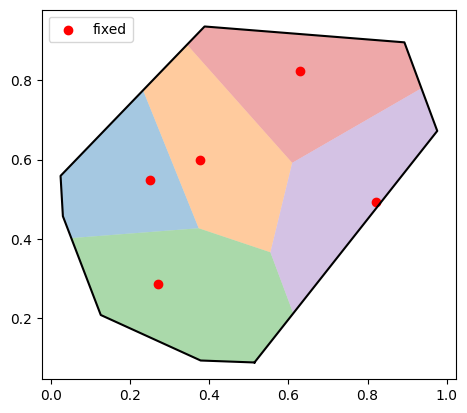

[n=1] feasible with min_cell_area = 0.0781
Voronoi cell areas: ['0.0781', '0.0923', '0.0791', '0.118', '0.0925', '0.0794']


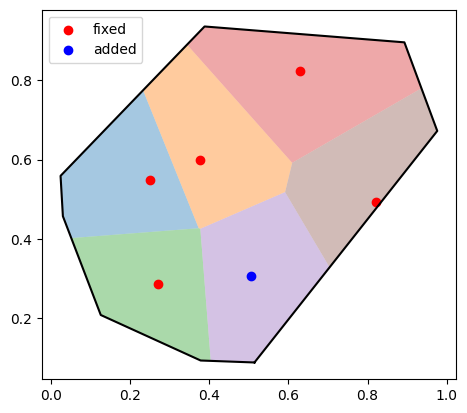

[n=2] feasible with min_cell_area = 0.0729
Voronoi cell areas: ['0.0781', '0.0729', '0.0739', '0.0769', '0.0729', '0.0861', '0.0788']


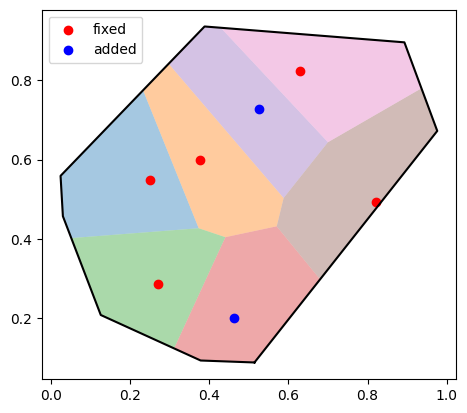

[n=4] feasible with min_cell_area = 0.0580
Voronoi cell areas: ['0.072', '0.058', '0.0596', '0.058', '0.058', '0.058', '0.0585', '0.0594', '0.058']


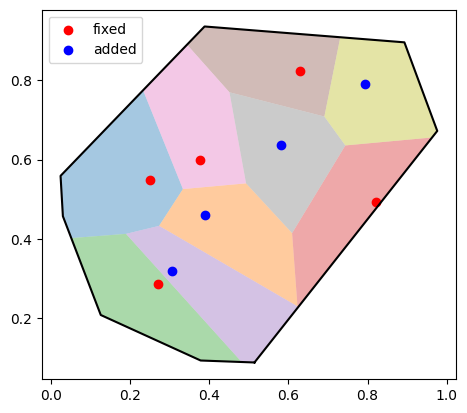

[n=8] feasible with min_cell_area = 0.0386
Voronoi cell areas: ['0.0388', '0.0482', '0.0386', '0.0409', '0.0386', '0.0434', '0.0391', '0.0386', '0.0388', '0.0557', '0.0387', '0.0391', '0.0412']


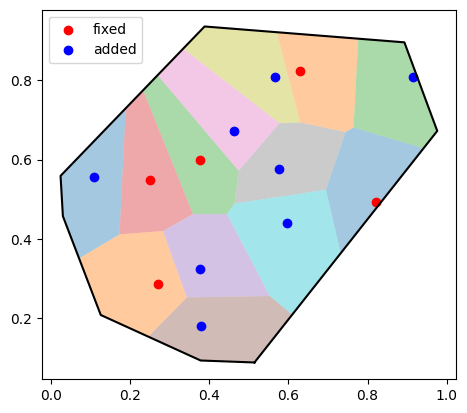

[n=16] not feasible with min_cell_area = 0.0211
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0271
[n=10] not feasible with min_cell_area = 0.0325
[n=9] not feasible with min_cell_area = 0.0332
Result → Max extra points: 8

=== QPSO (original) ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


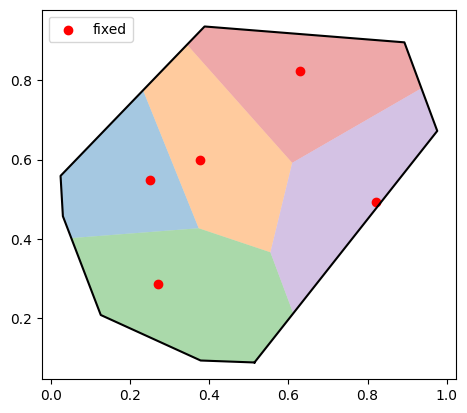

[n=1] feasible with min_cell_area = 0.0781
Voronoi cell areas: ['0.0781', '0.0986', '0.0823', '0.0807', '0.118', '0.0816']


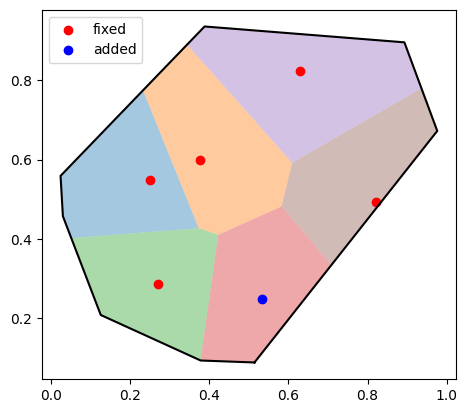

[n=2] feasible with min_cell_area = 0.0634
Voronoi cell areas: ['0.0769', '0.0726', '0.0634', '0.117', '0.0677', '0.0661', '0.076']


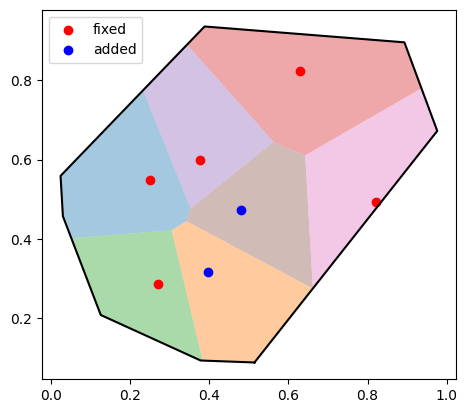

[n=4] feasible with min_cell_area = 0.0517
Voronoi cell areas: ['0.0765', '0.0528', '0.0756', '0.0634', '0.053', '0.0584', '0.0517', '0.0543', '0.0541']


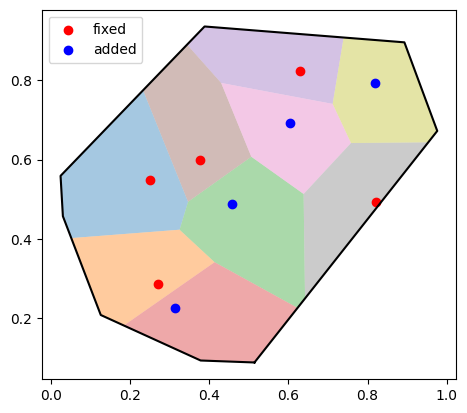

[n=8] not feasible with min_cell_area = 0.0345
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0384
Voronoi cell areas: ['0.0426', '0.0407', '0.0417', '0.0392', '0.0384', '0.0451', '0.0569', '0.0472', '0.0533', '0.0788', '0.0561']


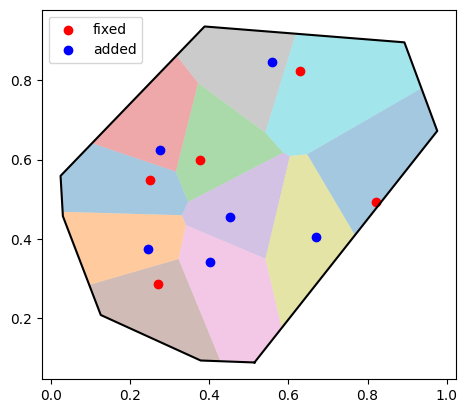

[n=7] feasible with min_cell_area = 0.0365
Voronoi cell areas: ['0.0495', '0.0408', '0.0441', '0.0634', '0.0365', '0.0424', '0.0443', '0.045', '0.0499', '0.0389', '0.0372', '0.0476']


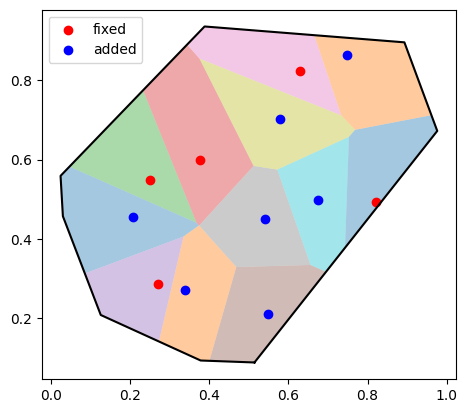

Result → Max extra points: 7

=== QPSO (pairwise) ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


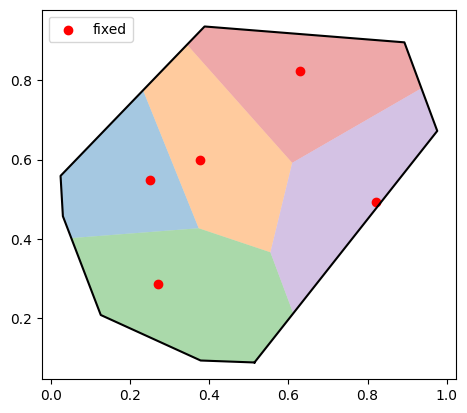

[n=1] feasible with min_cell_area = 0.0748
Voronoi cell areas: ['0.0781', '0.103', '0.0748', '0.076', '0.118', '0.0895']


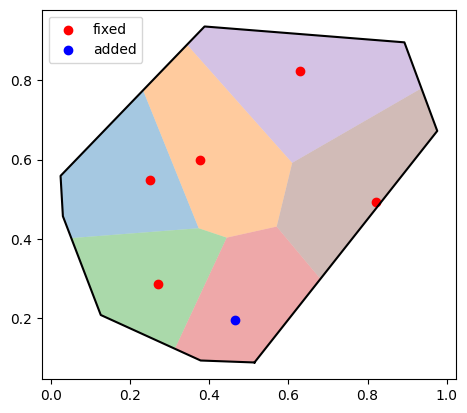

[n=2] feasible with min_cell_area = 0.0571
Voronoi cell areas: ['0.0781', '0.0708', '0.132', '0.0661', '0.0773', '0.0571', '0.0586']


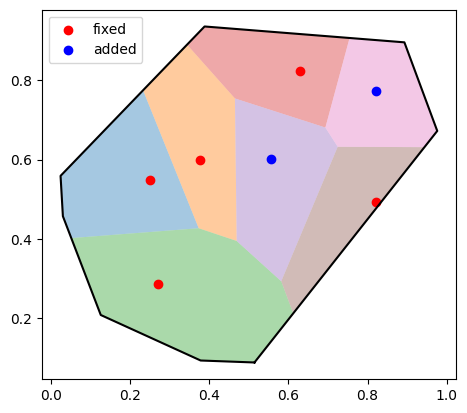

[n=4] feasible with min_cell_area = 0.0402
Voronoi cell areas: ['0.0445', '0.0843', '0.0596', '0.0402', '0.0786', '0.0686', '0.0577', '0.0631', '0.0431']


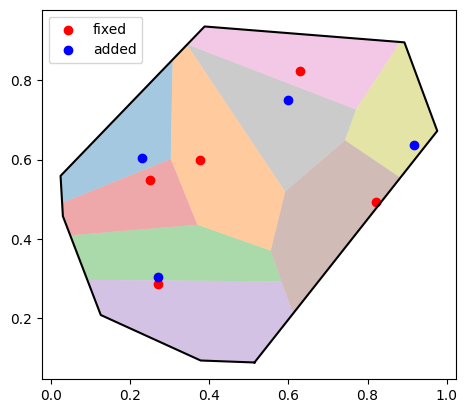

[n=8] feasible with min_cell_area = 0.0367
Voronoi cell areas: ['0.0378', '0.0487', '0.046', '0.0416', '0.0388', '0.041', '0.0484', '0.037', '0.0405', '0.0371', '0.0414', '0.0367', '0.0448']


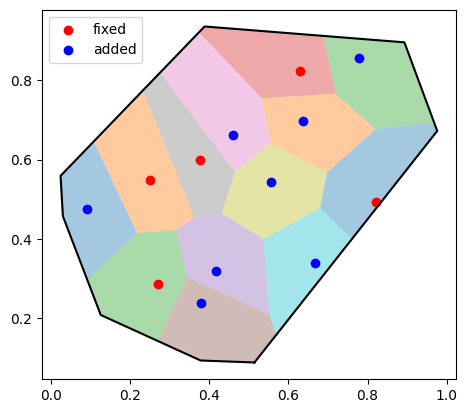

[n=16] not feasible with min_cell_area = 0.0162
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0246
[n=10] not feasible with min_cell_area = 0.0288
[n=9] not feasible with min_cell_area = 0.0320
Result → Max extra points: 8

=== GA Solver ===
Minimum area threshold (A_min): 0.0360
[n=0] feasible
Voronoi cell areas: ['0.0781', '0.107', '0.134', '0.118', '0.102']


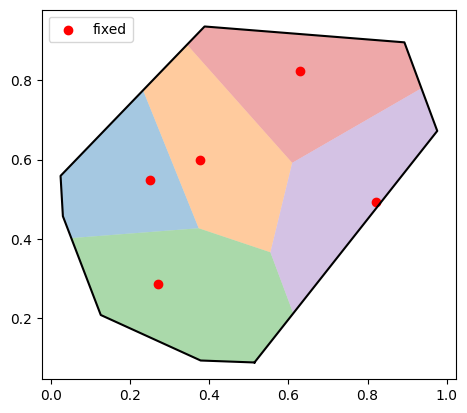

[n=1] feasible with min_cell_area = 0.0769
Voronoi cell areas: ['0.0781', '0.0929', '0.0839', '0.118', '0.0896', '0.0769']


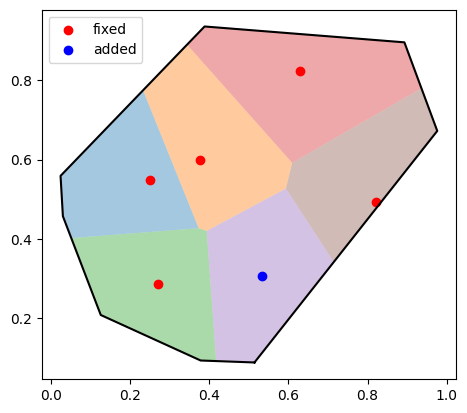

[n=2] feasible with min_cell_area = 0.0696
Voronoi cell areas: ['0.0781', '0.0696', '0.0946', '0.0702', '0.0777', '0.0727', '0.0767']


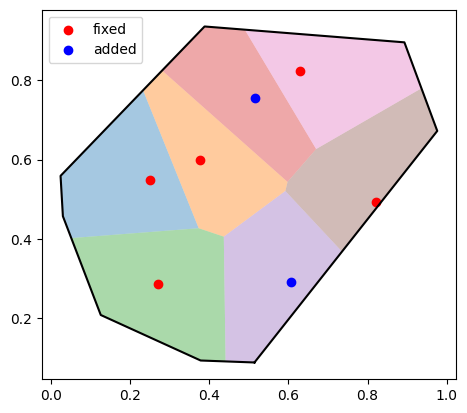

[n=4] feasible with min_cell_area = 0.0423
Voronoi cell areas: ['0.0423', '0.0427', '0.0613', '0.0996', '0.0675', '0.0793', '0.0468', '0.0565', '0.0438']


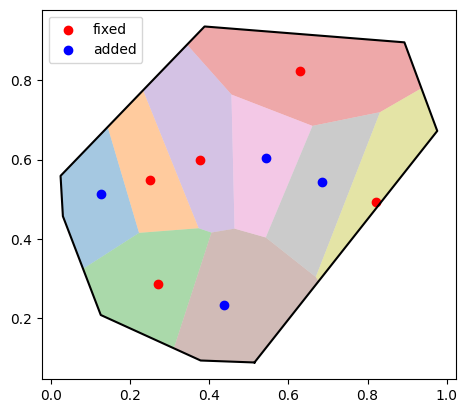

[n=8] feasible with min_cell_area = 0.0362
Voronoi cell areas: ['0.0417', '0.0362', '0.0469', '0.0528', '0.0404', '0.0431', '0.0364', '0.0382', '0.0364', '0.0487', '0.0433', '0.0382', '0.0375']


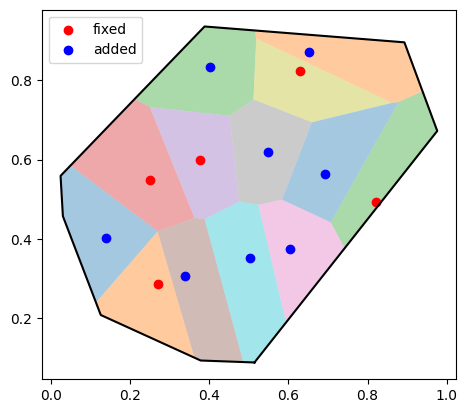

[n=16] not feasible with min_cell_area = 0.0227
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0277
[n=10] not feasible with min_cell_area = 0.0330
[n=9] feasible with min_cell_area = 0.0360
Voronoi cell areas: ['0.0397', '0.0385', '0.036', '0.0368', '0.0415', '0.0361', '0.0387', '0.0388', '0.039', '0.0366', '0.0462', '0.0389', '0.0364', '0.0365']


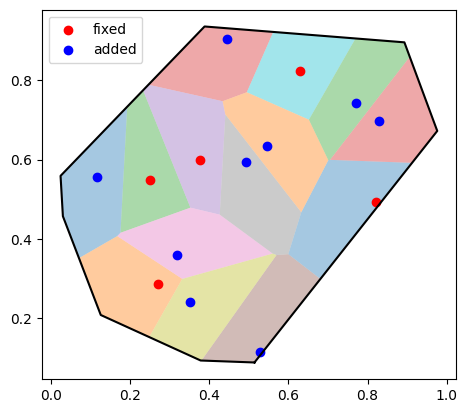

Result → Max extra points: 9


In [10]:
# Updated Example Usage in main.py with improved accuracy parameters

if __name__ == "__main__":
    import numpy as np
    import random
    from shapely.geometry import Point, MultiPoint

    # Reproducible example seed
    random.seed(3)
    np.random.seed(3)

    # Generate random convex polygon
    pts = np.random.rand(30, 2)
    polygon = MultiPoint([tuple(p) for p in pts]).convex_hull

    # Pick 5 fixed interior points
    fixed = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(fixed) < 5:
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        if polygon.contains(Point(x, y)):
            fixed.append((x, y))

    # Minimum area threshold
    A_min = polygon.area / 15

    # Improved parameter dictionaries for higher accuracy
    custom_params = {
        "maxiter": 200,    # more generations
        "popsize": 30,     # larger population
        "F": 0.9,          # stronger mutation
        "CR": 0.8,         # higher crossover rate
        "seed": None
    }

    scipy_params = {
        "maxiter": 200,    # more iterations
        "popsize": 30,     # larger population
        "seed": None
    }

    qpso_params = {
        "maxiter": 200,    # more iterations
        "popsize": 30,     # larger swarm
        "alpha": 0.85,     # adjust contraction-expansion
        "seed": None
    }

    ga_params = {
        "popsize": 100,    # much larger population
        "ngen": 80,        # more generations
        "cxpb": 0.7,       # higher crossover probability
        "mutpb": 0.4,      # higher mutation probability
        "sigma": 0.05,     # smaller mutation step-size
        "indpb": 0.2,      # increase per-gene mutation chance
        "seed": None
    }

    # Run with different solvers
    print("=== Custom DE ===")
    find_max_additional(fixed, polygon, A_min, custom_params, solver="custom")

    print("\n=== SciPy DE ===")
    find_max_additional(fixed, polygon, A_min, scipy_params, solver="scipy")

    print("\n=== QPSO (original) ===")
    find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso")

    print("\n=== QPSO (pairwise) ===")
    find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso2")

    print("\n=== GA Solver ===")
    find_max_additional(fixed, polygon, A_min, ga_params, solver="ga")
